# Gate Optimization with Autodiff

<span style="font-variant: small-caps;">Simphony</span> is a Python package designed for **simulating the spin dynamics** of point defects, in particular the nitrogen-vacancy (NV) center, which is surrounded by nuclear spins and serves as a **central-spin quantum register**.

This tutorial demonstrates how to leverage <span style="font-variant: small-caps;">Simphony</span>'s **automatic differentiation (autodiff)** capabilities to **optimize a quantum gate** at the pulse level.

We will:
- Define a physical model based on NV-center spins  
- Set up an objective function using gate **infidelity**  
- Use autodiff to compute gradients  
- Apply gradient-based optimization to improve gate fidelity  


## Import the packages

First, **enable automatic differentiation** in <span style="font-variant: small-caps;">Simphony</span>, set the computation to run on the GPU — highly recommended for autodiff — and import the required packages:

In [1]:
import simphony
simphony.Config.set_platform('gpu')
simphony.Config.set_autodiff_mode(True)
simphony.Config.set_matplotlib_format('retina')

import numpy as np
import jax.numpy as jnp

from qiskit import QuantumCircuit

from matplotlib import pyplot as plt

## Define the model

We use a predefined NV-center model from <span style="font-variant: small-caps;">Simphony</span>, which includes the electron spin and the nitrogen nuclear spin, but no carbon nuclear spins:

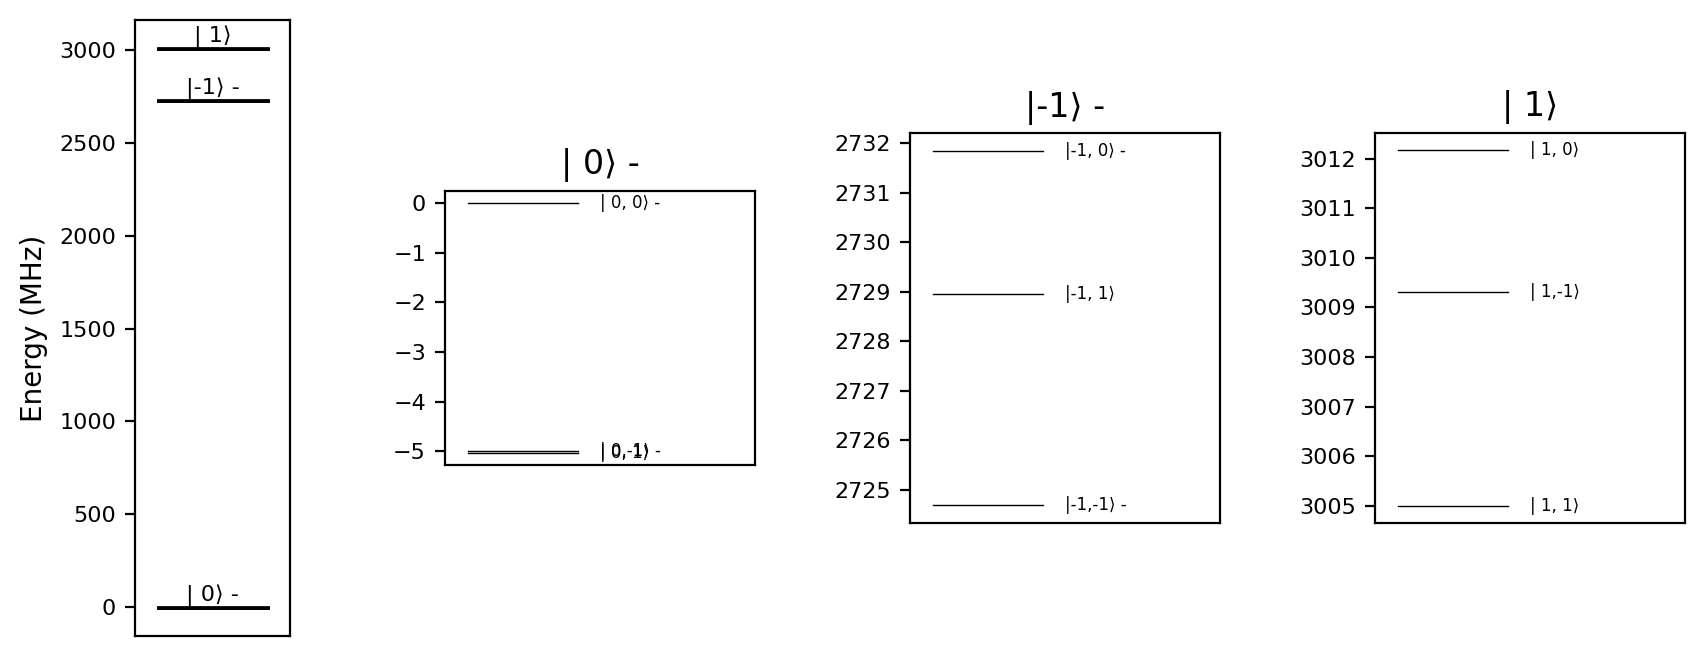

['e', 'N']

In [2]:
model = simphony.default_nv_model(nitrogen_isotope = 14,
                                  static_field_strength = 0.005)
model.plot_levels()
model.spin_names

## Infidelity as the Objective Function

To perform autodiff, we first define an **objective function** as a **Python function**. Infidelity quantifies how far the implemented gate deviates from the target ideal gate, making it a natural choice for the objective function.  

We start by implementing an **$RX(\pi/2)$ gate on the electron spin** using a resonant pulse with a rectangular envelope. Since the electron spin splitting depends on the state of the nitrogen nuclear spin, we set the driving frequency to the **average electron spin splitting** across nuclear spin states. The pulse duration will be treated as the optimization variable, while the amplitude is set to achieve a $\pi/2$ rotation — corresponding to a quarter of a Rabi oscillation:

In [3]:
frequency = model.splitting_qubit(spin_name='e')
qc = QuantumCircuit(2)
qc.rx(np.pi/2,0)

def infidelity(duration, model):

    period_time = 4 * duration # 4 -> pi/2 gate
    amplitude = model.rabi_cycle_amplitude_qubit(driving_field_name = 'MW_x',
                                                 spin_name = 'e', 
                                                 period_time = period_time)
    
    model.remove_all_pulses()
    model.driving_field('MW_x').add_rectangle_pulse(frequency = frequency,
                                                    amplitude = amplitude,
                                                    duration = duration,
                                                    phase = 0)

    result = model.simulate_time_evolution(n_eval=2)
    result.ideal = qc
    return 1 - result.average_gate_fidelity()

We can compute the gate fidelity for a given pulse duration:

In [4]:
duration = 0.03
infidelity(duration, model)

Array(0.0150144, dtype=float64)

Alternatively, we can scan the `duration` parameter over a specified range:

In [5]:
durations = np.linspace(0.003, 0.03, 251)
infidelities = np.array([infidelity(duration, model) for duration in durations])

We can visualize the **infidelity as a function of** the pulse **duration**:

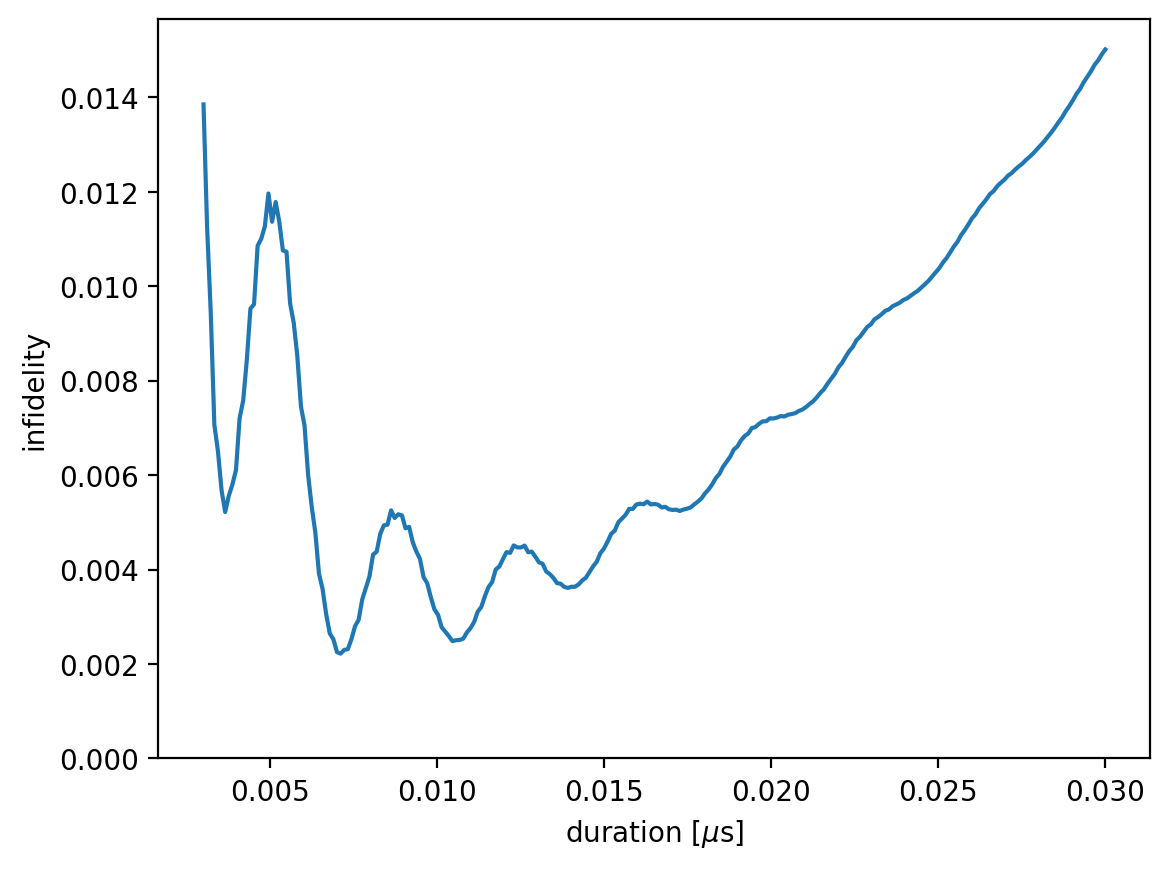

In [6]:
plt.plot(durations, infidelities, '-')
plt.xlabel('duration [$\mu$s]')
plt.ylabel('infidelity')
plt.ylim(0)
plt.show()

At short pulse durations, the infidelity is high due to **leakage** out of the computational subspace. At longer durations—corresponding to weaker amplitude—**frequency-averaged driving cannot achieve resonance** regardless of the nuclear spin state, leading to a gradual increase in infidelity. **Bloch–Siegert oscillations** appear due to the presence of the counter-rotating term, which is retained since the rotating wave approximation (RWA) is not applied.

To observe the leakage explicitly, we can calculate it as follows:

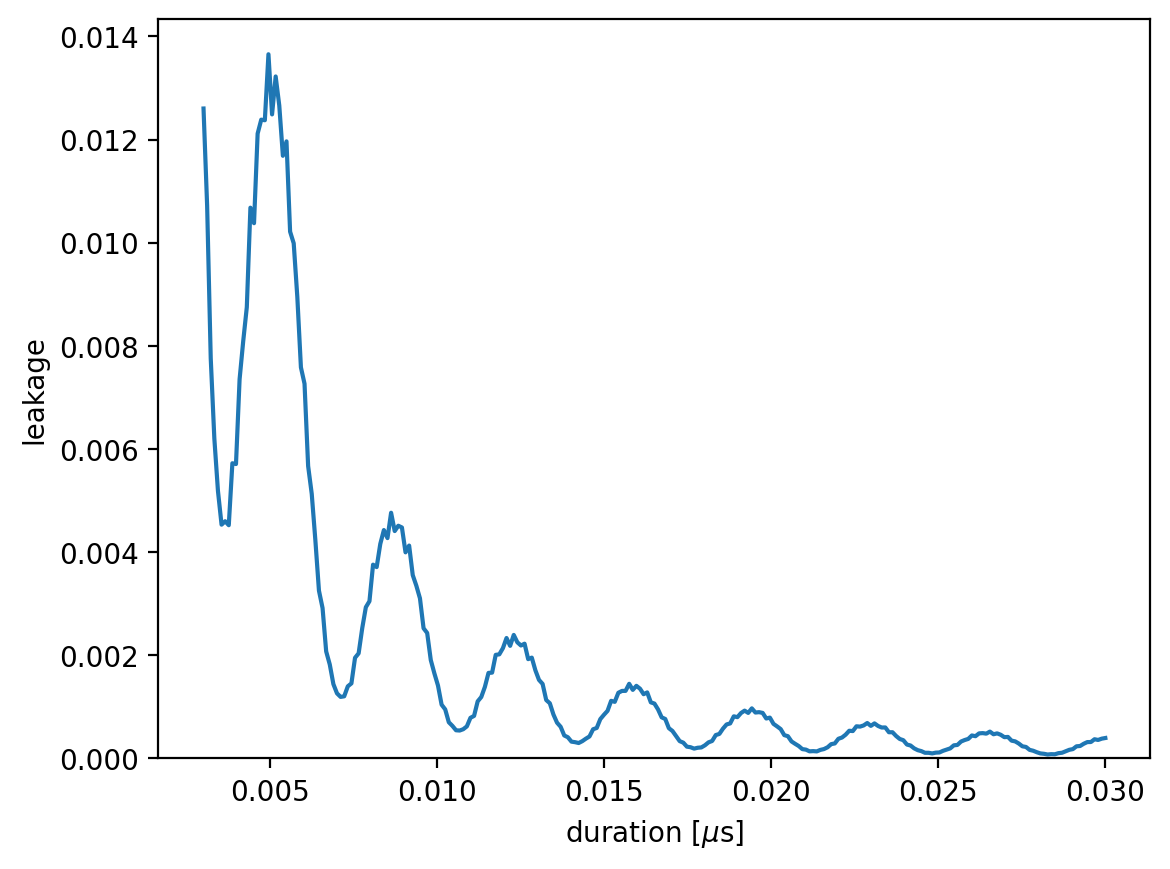

In [7]:
def leakage(duration, model):

    period_time = 4 * duration
    amplitude = model.rabi_cycle_amplitude_qubit(driving_field_name = 'MW_x',
                                                 spin_name = 'e', 
                                                 period_time = period_time)
    
    model.remove_all_pulses()
    model.driving_field('MW_x').add_rectangle_pulse(frequency = frequency,
                                                    amplitude = amplitude,
                                                    duration = duration,
                                                    phase = 0)

    result = model.simulate_time_evolution(n_eval=2)
    return result.leakage()

leakages = np.array([leakage(duration, model) for duration in durations])

plt.plot(durations, leakages, '-')
plt.xlabel('duration [$\mu$s]')
plt.ylabel('leakage')
plt.ylim(0)
plt.show()

The optimal pulse duration is:

In [8]:
durations[np.argmin(infidelities)]

np.float64(0.007104)

## Autodiff with JAX and Simple Gradient Descent

To compute the gradient, we use JAX’s `value_and_grad` function:

In [9]:
from jax import value_and_grad

value_and_grad_infidelity = value_and_grad(infidelity)

The `value_and_grad_infidelity` function works similarly to the `infidelity` function, but returns a tuple:  
- The first element is the infidelity value.  
- The second element is the gradient with respect to the first argument of the `infidelity` function, returned as a JAX `Array`:

In [10]:
duration = 0.03
value_and_grad_infidelity(duration, model)

(Array(0.0150144, dtype=float64),
 Array(1.3289286, dtype=float64, weak_type=True))

We illustrate gate optimization starting from an initial pulse duration using gradient descent. The procedure involves iteratively computing the gradient and updating the duration according to:

$$
\text{duration}_{i+1} = \text{duration}_{i} - \epsilon \cdot \text{grad}_i,
$$

where $\epsilon$ is the learning rate:


In [11]:
duration = 0.03
epsilon = 1e-3
n_step = 25

infidelities_optimized = []
durations_optimized = []

for i in range(n_step):
    
    value, grad = value_and_grad_infidelity(duration, model)
    infidelities_optimized.append(value)
    durations_optimized.append(duration)

    duration -= epsilon*grad
    print(f'{i+1}/{n_step}', end=' ')

1/25 2/25 3/25 4/25 5/25 6/25 7/25 8/25 9/25 10/25 11/25 12/25 13/25 14/25 15/25 16/25 17/25 18/25 19/25 20/25 21/25 22/25 23/25 24/25 25/25 

We can visualize the optimization process:

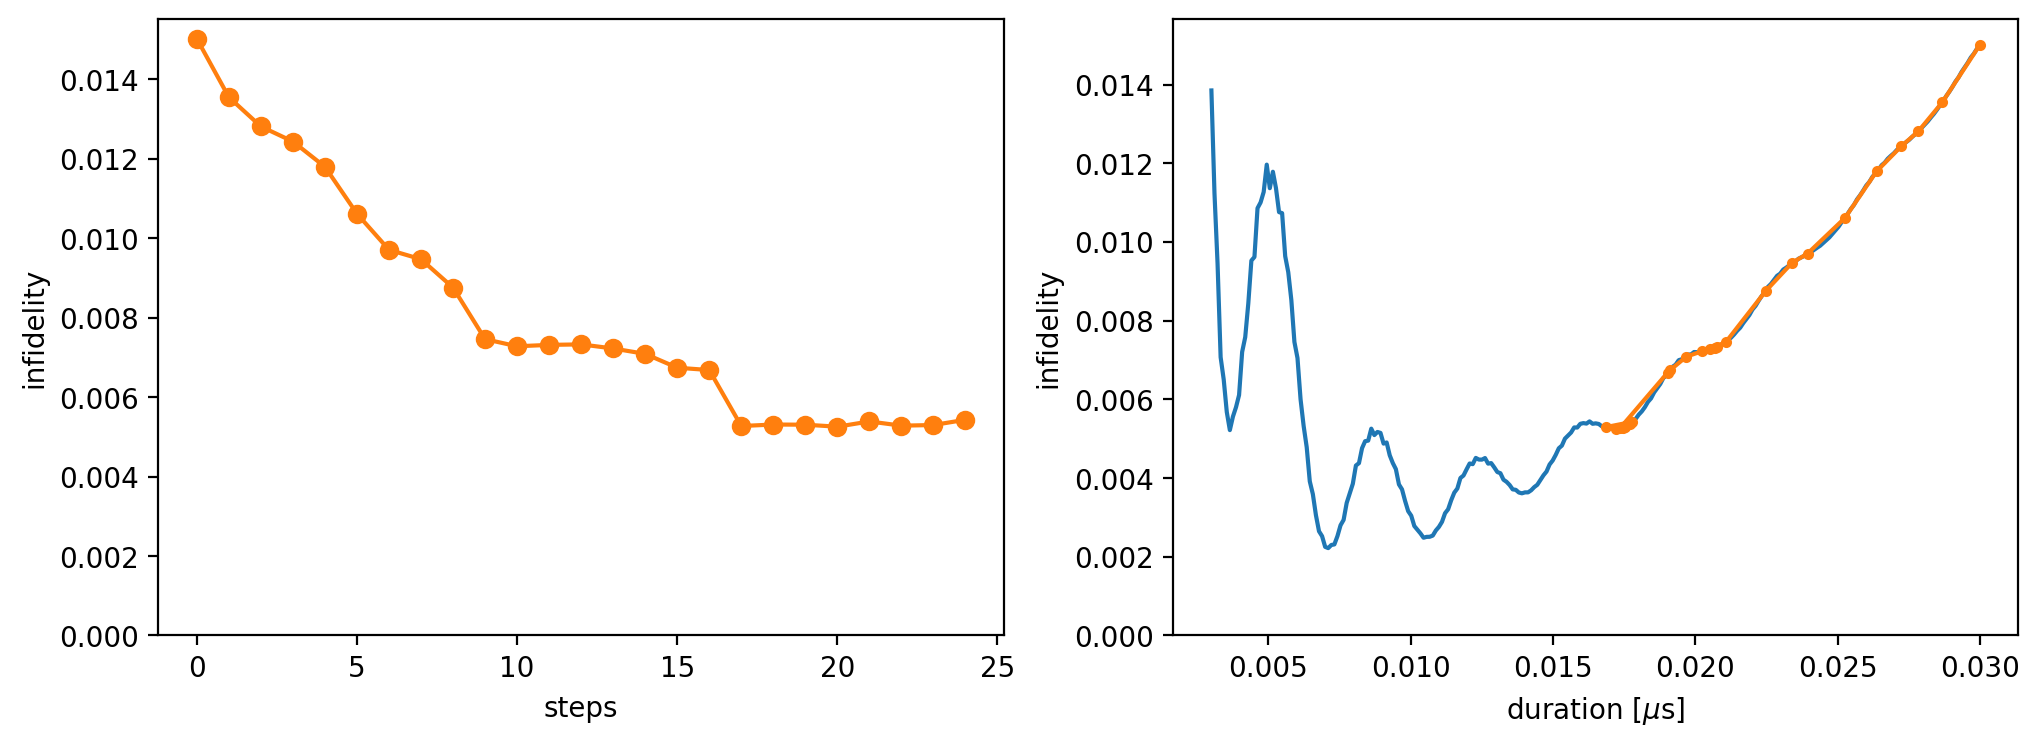

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(infidelities_optimized, 'o-', c='#ff7f0e')
axs[0].set_xlabel('steps')
axs[0].set_ylabel('infidelity')
axs[0].set_ylim(0)

axs[1].plot(durations, infidelities, '-')
axs[1].plot(durations_optimized, infidelities_optimized, '.-')
axs[1].set_xlabel('duration [$\mu$s]')
axs[1].set_ylabel('infidelity')
axs[1].set_ylim(0)

plt.show()

In the left plot, the **infidelity** is shown as a function of the **number of optimization steps**. In the right plot, we show the **trajectory of the optimization on the landscape**.  

Note: For **oscillatory landscapes**, the optimization problem becomes non-trivial and may require a **more sophisticated optimization method**.

## Optimize a Pulse Sequence

As a second example, we consider a more complex scenario: optimizing a **pulse sequence with a piecewise-constant envelope**. The optimization variables are real numbers, where:  
- **even-indexed parameters** correspond to the **real parts** of the envelope segments
- **odd-indexed parameters** correspond to the **imaginary parts**

In [13]:
def infidelity_2(parameters, dt, model):

    samples = parameters[::2] + 1j*parameters[1::2]
    
    model.remove_all_pulses()
    model.driving_field('MW_x').add_discrete_pulse(frequency = frequency,
                                                   samples = samples,
                                                   dt = dt)

    result = model.simulate_time_evolution(n_eval=2)
    result.ideal = qc
    return 1 - result.average_gate_fidelity()

value_and_grad_infidelity_2 = value_and_grad(infidelity_2)

Gradient descent is initialized from a **randomly generated pulse sequence**. The sequence consists of **8 constant-envelope pulse segments** with a total duration of **0.01 μs**. The optimization runs for **100 iterations**.  

**Note:** Executing this code may take several minutes, depending on system performance:


In [14]:
np.random.seed(42)

N = 8
duration = 0.01
dt = duration / N
parameters = 0.1 * (np.random.random(2 * N) - 0.5)

epsilon = 2e-5
n_step = 100

infidelities_optimized = []

for i in range(n_step):
    
    value, grads = value_and_grad_infidelity_2(parameters, dt, model)
    infidelities_optimized.append(value)

    parameters -= epsilon*grads
    print(f'{i+1}/{n_step}', end=' ')

1/100 2/100 3/100 4/100 5/100 6/100 7/100 8/100 9/100 10/100 11/100 12/100 13/100 14/100 15/100 16/100 17/100 18/100 19/100 20/100 21/100 22/100 23/100 24/100 25/100 26/100 27/100 28/100 29/100 30/100 31/100 32/100 33/100 34/100 35/100 36/100 37/100 38/100 39/100 40/100 41/100 42/100 43/100 44/100 45/100 46/100 47/100 48/100 49/100 50/100 51/100 52/100 53/100 54/100 55/100 56/100 57/100 58/100 59/100 60/100 61/100 62/100 63/100 64/100 65/100 66/100 67/100 68/100 69/100 70/100 71/100 72/100 73/100 74/100 75/100 76/100 77/100 78/100 79/100 80/100 81/100 82/100 83/100 84/100 85/100 86/100 87/100 88/100 89/100 90/100 91/100 92/100 93/100 94/100 95/100 96/100 97/100 98/100 99/100 100/100 

Infidelity is plotted as a function of the **number of optimization steps**. Starting from an initial gate with **infidelity near unity**, the optimization gradually converges toward **zero infidelity** using a highly conservative learning rate.  

While a higher learning rate could accelerate convergence, it often leads to **suboptimal gate performance**. In such cases, **more advanced optimization methods** are needed to achieve better gate fidelities and faster convergence.

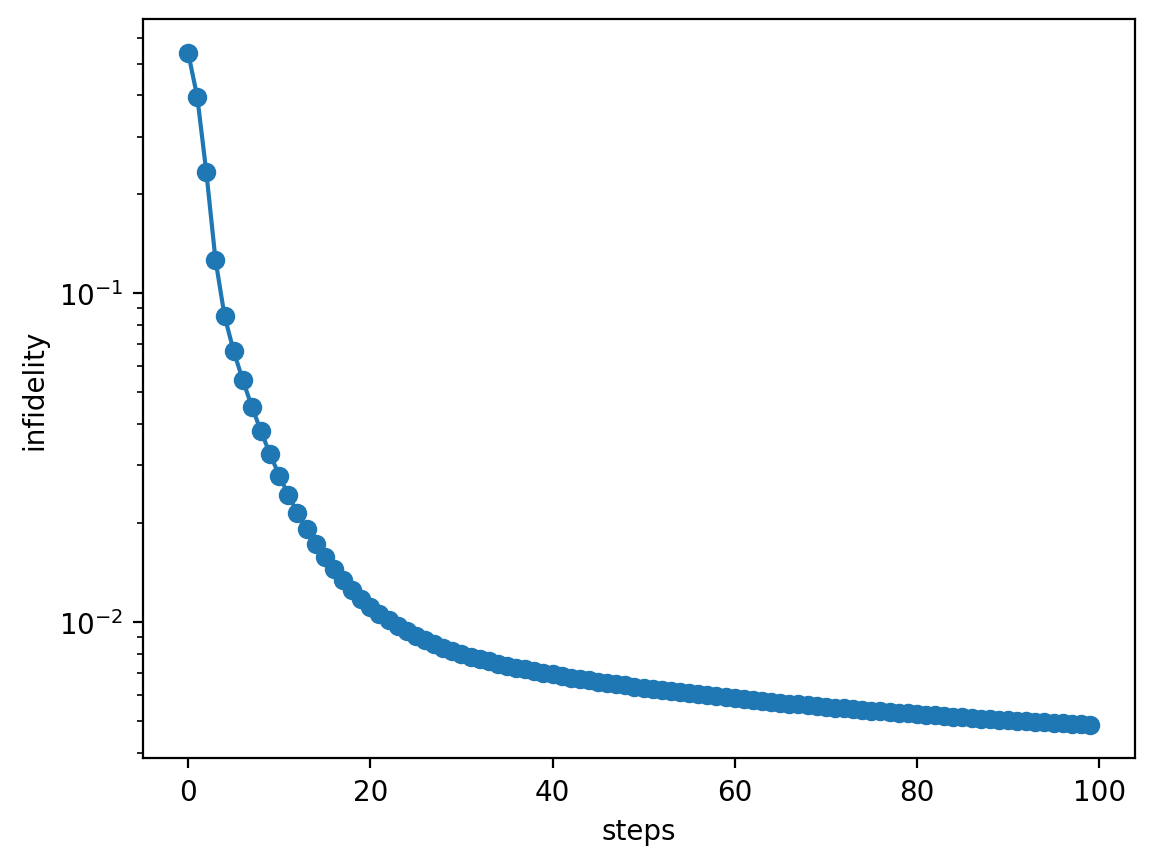

In [15]:
plt.plot(infidelities_optimized, 'o-')
plt.ylabel('infidelity')
plt.xlabel('steps')
plt.yscale('log')
plt.show()

The resulting optimized pulse sequence is shown below:

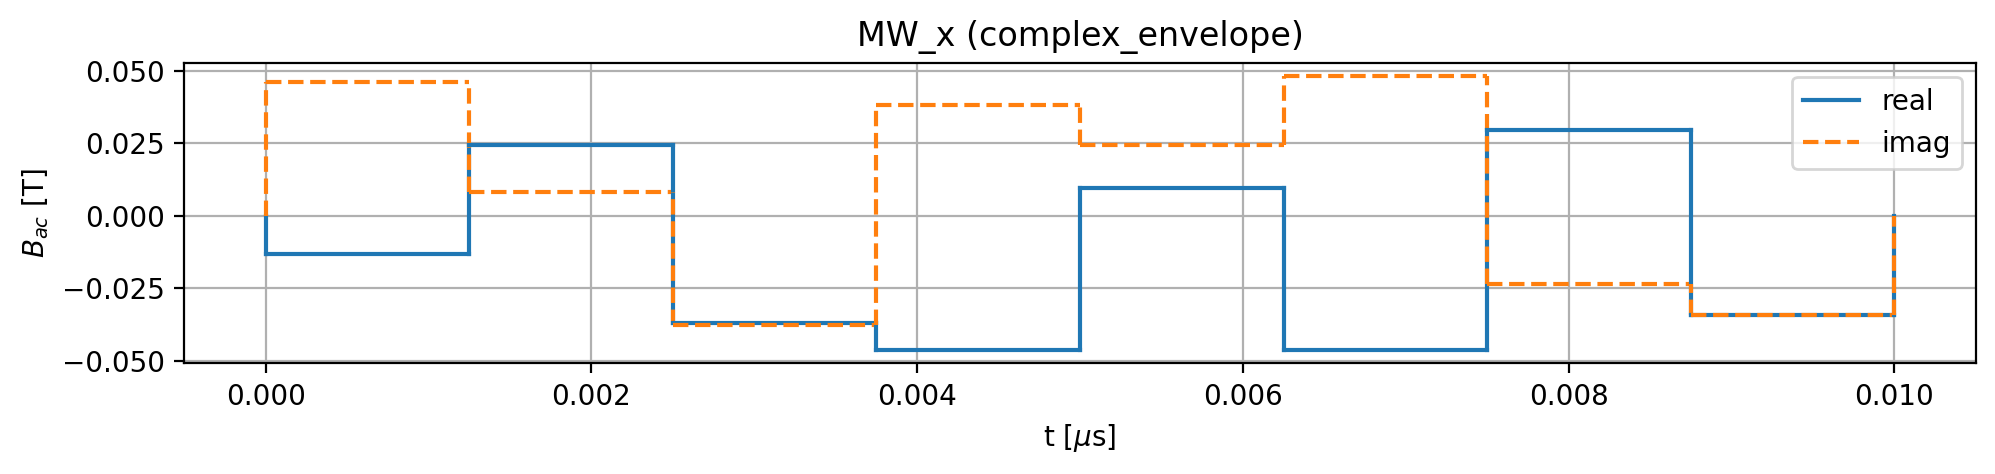

In [16]:
model.driving_field('MW_x').plot_pulses(function='complex_envelope')

**Note:** This optimization process is conceptually similar to the **Gradient Ascent Pulse Engineering (GRAPE)** method, but **does not rely on the rotating wave approximation (RWA)**.